In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import pandas as pd
import numpy as np

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

In [18]:
deg = np.pi/180

system = System(init = State(Vx = 0, Vy = 0, X = 0, Y = 0, B = 0, Wb=0),
                w = 10,
                d = 30 * deg,
                r = 0.3,
                I = 2500,
                l = 2.52,
                h = 0.28,
                m = 1250,
                Fxk = Params(B = 0.12, C = 1.48, D = 3308, E = 0.01, K = 100),
                Fya = Params(B = 0.08, C = 1.44, D = 6004, E = -1.84, K = 90),
                t_end = 20 
                )

,values
init,Vx 0 Vy 0 X 0 Y 0 B 0 Wb ...
w,10
d,0.523599
r,0.3
I,2500
l,2.52
h,0.28
m,1250
Fxk,B 0.12 C 1.48 D 3308.00 E ...
Fya,B 0.08 C 1.44 D 6004.00 E ...


In [19]:
def AlphaF(sys, state):
    unpack(sys)
    Vx, Vy, X, Y, B, Wb = state
    
    Vxf = Vx
    Vyf = Vy - Wb * (l/2)
    
    if(Vxf == 0):
        Vxf = 1e-99
    
    af = np.arctan(Vyf / Vxf) - d
    
    #print("AlphaF")
    #print(af)
    
    return af
    
    
def AlphaR(sys, state):
    unpack(sys)
    Vx, Vy, X, Y, B, Wb = state
    
    Vxr = Vx
    Vyr = Vy - Wb * (l/2)
    
    if(Vxr == 0):
        Vxr = 1e-99
        
    ar = np.arctan(Vyr / Vxr)
    
    #print("AlphaR")
    #print(ar)
    
    return ar

In [20]:
def slip(sys, state):
    unpack(sys)
    Vx, Vy, X, Y, B, Wb = state
    
    K = (r * w - Vx) / (r * w)
    
    #print("slip")
    #print(K)
    
    return K

In [21]:
def BNPFrictionX(sys, state, k):
    unpack(sys)
    #unpack(Fxk)
    
    phi = (1-Fxk.E)*Fxk.K*k + (Fxk.E/Fxk.B)*np.arctan(Fxk.B*Fxk.K*k)
    Fx  = Fxk.D*np.sin(Fxk.C*np.arctan(Fxk.B*phi))
    
    #print("BNPFrictionX")
    #print(Fx)
    
    return Fx

In [22]:
def BNPFrictionY(sys, state, a):
    unpack(sys)
    #unpack(Fya)
    
    #print(a)
    
    phi = (1-Fya.E)*Fya.K*a + (Fya.E/Fya.B)*np.arctan(Fya.B*Fya.K*a)
    Fy  = Fya.D*np.sin(Fya.C*np.arctan(Fya.B*phi))
    
    #print("BNPFrictionY")
    #print(Fy)
    
    return Fy

In [23]:
def NCForceX(sys, state, a, k):
    unpack(sys)    
    
    Fx = BNPFrictionX(sys, state, k)
    Fy = BNPFrictionY(sys, state, a)
    
    num   = Fx*Fy*k
    denom = (k**2 * Fy**2 + Fx**2 * np.tan(a)**2)**.5
    
    if(denom == 0):
        print('Yikes, NCForceX')
    
    F = num/denom
    
    #print("NCForceX")
    #print(F)
    
    return F

In [24]:
def NCForceY(sys, state, a, k):
    unpack(sys)    
    
    Fx = BNPFrictionX(sys, state, k)
    Fy = BNPFrictionY(sys, state, a)
    
    num   = Fx*Fy*np.tan(a)
    denom = (k**2 * Fy**2 + Fx**2 * np.tan(a)**2)**.5
    
    if(denom == 0):
        print('Yikes, NCForceY')
    
    F = num/denom
    
    #print("NCForceY")
    #print(F)
    
    return F

In [25]:
def slopeFunc(state, t, sys):
    unpack(sys)
    Vx, Vy, X, Y, B, Wb = state
    
    if(t==0):
        af = d
    else:
        af = AlphaF(sys, state)
        if(af == 0):
            print('af')
            print(t)
            af = 1e-99
    
    if(t==0):
        ar = 1e-99
    else:
        ar = AlphaR(sys, state)
        if(ar == 0):
            print('ar')
            print(t)
            ar = 1e-99
    
    kf = 1e-99
    kr = slip(sys, state)
    if(kr == 0):
        print(t)
        kr = 1e-99
    
    Fxwf = 1e-99
    Fywf = NCForceY(sys, state, af, kf)
    
    Fxwr = NCForceX(sys, state, ar, kr)
    Fywr = NCForceY(sys, state, ar, kr)
    
    Fx = Fxwr + Fxwf * np.cos(d) - Fywf * np.sin(d)
    Fy = Fywr + Fxwf * np.sin(d) + Fywf * np.cos(d)
    
    T = (l / 2) * (Fywr - Fxwf * np.sin(d) - Fywf * np.cos(d))
    
    dBdt = Wb
    dWbdt = T / I
    dXdt = Vx
    dYdt = Vy
    dVxdt = Fx / m
    dVydt = Fy / m
    
    return dVxdt, dVydt, dXdt, dYdt, dBdt, dWbdt 

In [26]:
slopeFunc(system.init, 0, system)

(0.07473894086337532, 3.571295405143859, 0, 0, 0, -2.249916105240631)

In [27]:
results, details = run_ode_solver(system, slopeFunc, max_step = 1)

In [28]:
results

,Vx,Vy,X,Y,B,Wb
0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
0.000100,0.000094,0.000051,4.536163e-09,4.328461e-09,1.567238e-08,0.000370
0.000206,0.000212,0.000082,2.079437e-08,1.137930e-08,7.967507e-08,0.000833
0.000793,0.000872,0.000253,3.385063e-07,1.093830e-07,1.315749e-06,0.003385
0.002894,0.003242,0.000871,4.661172e-06,1.290715e-06,1.804160e-05,0.012534
0.013535,0.015258,0.004014,1.030688e-04,2.726632e-05,3.979368e-04,0.058870
0.059635,0.067566,0.017833,2.010539e-03,5.295432e-04,7.741020e-03,0.259741
0.195938,0.224723,0.060655,2.188734e-02,5.845066e-03,8.368532e-02,0.854916
0.531450,0.628941,0.178820,1.643660e-01,4.550547e-02,6.173300e-01,2.328115
1.351977,1.751116,0.545051,1.125858e+00,3.351253e-01,4.021332e+00,5.980542


In [29]:
def plotPath(results, label):
    plot(results.X, results.Y, label = label)
    
    decorate(xlabel = 'x position (m)',
             ylabel = 'y position (m)')
    

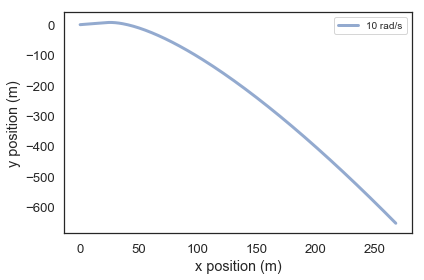

In [32]:
plotPath(results, '10 rad/s')

In [ ]:
plot(results)

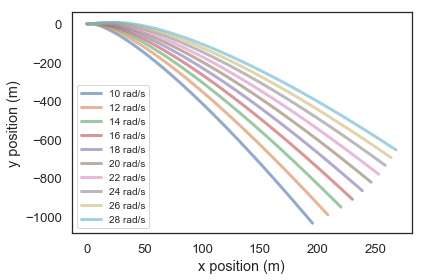

In [31]:
wRange = linrange(10, 30, 2)

for w in wRange:
    sys = System(system, w=w)
    results, details = run_ode_solver(sys, slopeFunc, max_step = .1)
    plotPath(results, str(w) + ' rad/s')

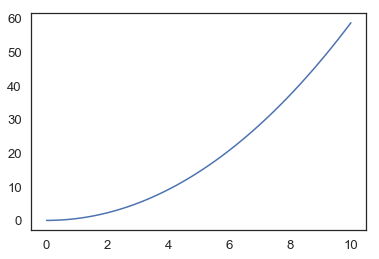

In [16]:
results.X.plot()

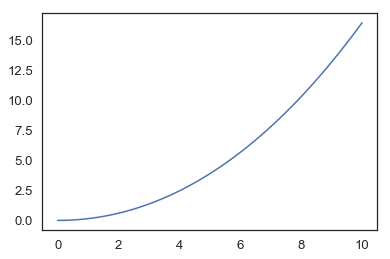

In [17]:
results.Y.plot()

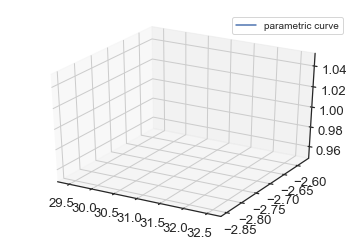

In [337]:
fig = plt.figure()
ax = fig.gca(projection='3d')

v = 33
t = np.linspace(1,10,1)
theta = np.pi/9
h = 2

# Prepare arrays x, y, z
z = 1
x = v*t*np.cos(theta)
y = -16*t**2 + v*t*np.sin(theta) + h



ax.plot(x, y, z, label='parametric curve')
ax.legend()

plt.show()